In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_excel('Data/Flight Price Prediction/train.xlsx')
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
train.shape

(10683, 11)

In [4]:
test = pd.read_excel('Data/Flight Price Prediction/test.xlsx')
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


**EDA and Feature Engineering**

In [5]:
train.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
train.dropna(inplace=True)

In [7]:
train.nunique()

Airline              12
Date_of_Journey      44
Source                5
Destination           6
Route               128
Dep_Time            222
Arrival_Time       1343
Duration            368
Total_Stops           5
Additional_Info      10
Price              1870
dtype: int64

In [8]:
train['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [9]:
def total_stops(x):
    if x == 'non-stop':
        return 1
    else:
        return int(x.split()[0])+1
train['Total_Stops'] = train['Total_Stops'].apply(total_stops) 
test['Total_Stops'] = test['Total_Stops'].apply(total_stops) 

In [10]:
def time(x):
    return int(x.split(':')[0]+x.split(':')[1])
train['Dep_Time'] = train['Dep_Time'].apply(time)
test['Dep_Time'] = test['Dep_Time'].apply(time)

In [11]:
train[~train['Duration'].apply(lambda x: True if 'h' in x else False)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,1650,16:55,5m,3,No info,17327


In [12]:
test[~test['Duration'].apply(lambda x: True if 'h' in x else False)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
2660,Air India,12/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,1650,16:55,5m,3,No info


In [13]:
train.loc[6474,'Duration'] = '5h' #its implausible that duration can be 5 m

In [14]:
test.loc[2660,'Duration'] = '5h'

In [15]:
def duration(x):
    if 'h' in x and 'm' in x:
        return int(x.split('h')[0])*60+int(x.split('h')[1][:-1])        
    else:
        return int(x.split('h')[0])*60
    
train['Duration'] = train['Duration'].apply(duration)
test['Duration'] = test['Duration'].apply(duration)

In [16]:
train.drop(columns = ['Route','Arrival_Time'], inplace = True)
test.drop(columns = ['Route','Arrival_Time'], inplace = True)

In [17]:
train.nunique()

Airline              12
Date_of_Journey      44
Source                5
Destination           6
Dep_Time            222
Duration            367
Total_Stops           5
Additional_Info      10
Price              1870
dtype: int64

In [18]:
test.nunique()

Airline             11
Date_of_Journey     44
Source               5
Destination          6
Dep_Time           199
Duration           319
Total_Stops          5
Additional_Info      6
dtype: int64

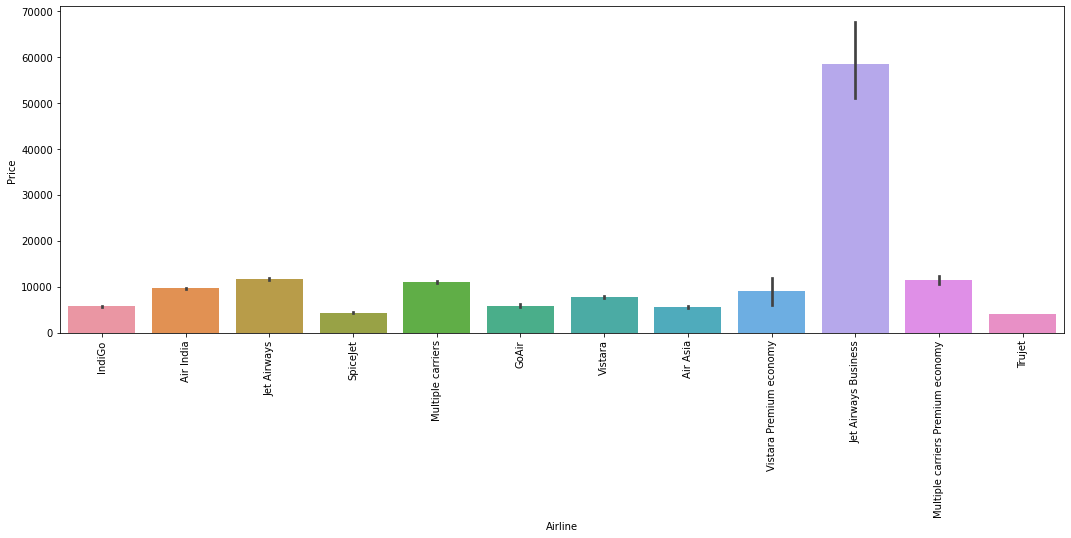

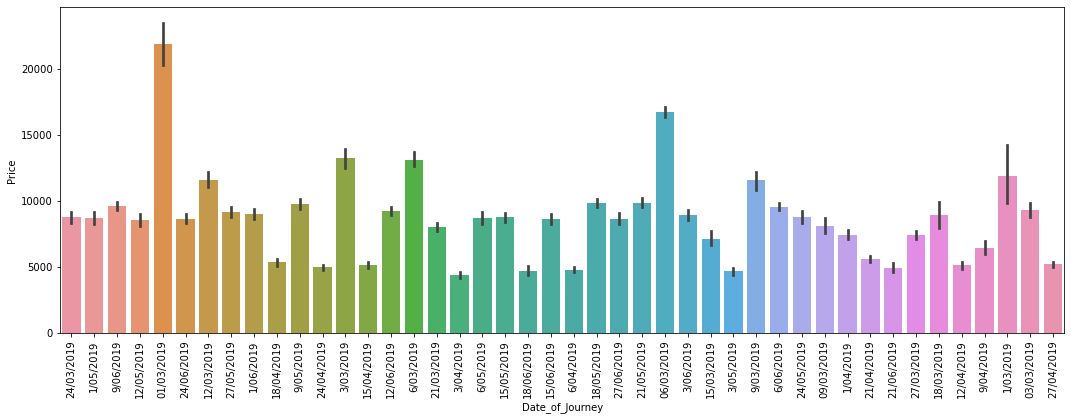

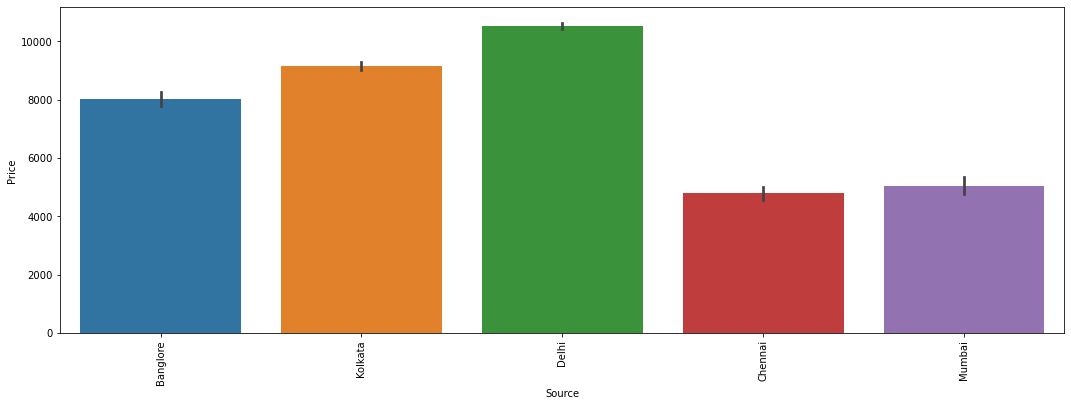

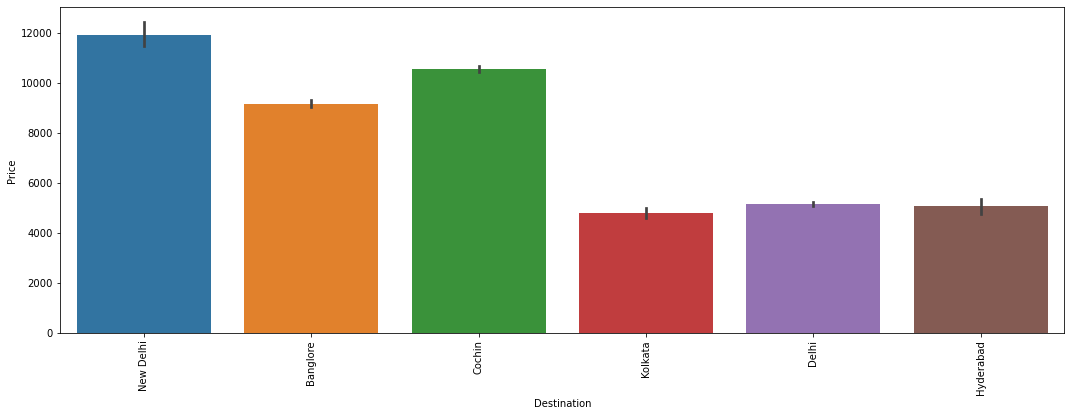

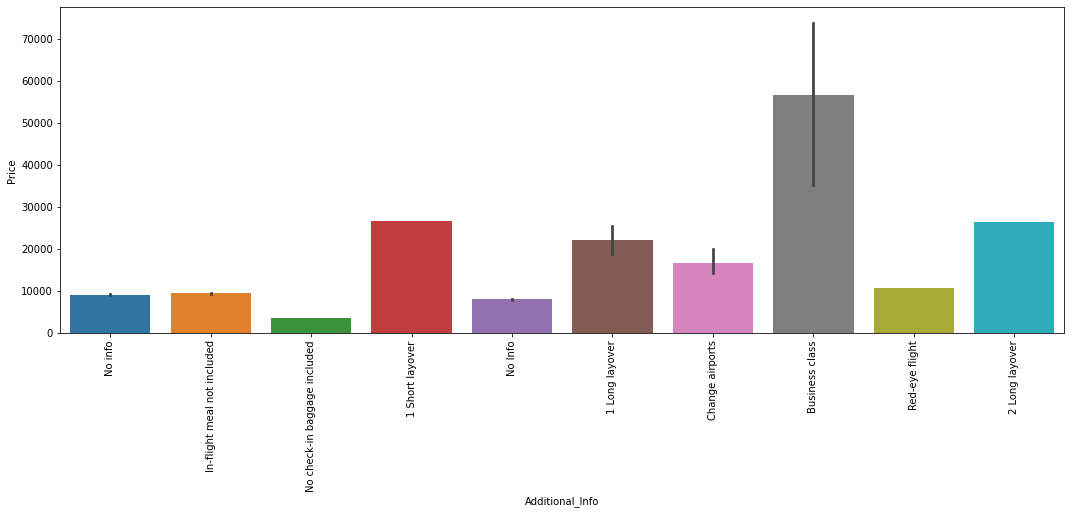

In [19]:
for i in train.select_dtypes('O').columns:
    plt.figure(figsize=(18,6))
    sns.barplot(x= i,y= 'Price',data=train)
    plt.xticks(rotation=90)
    plt.show()

In [20]:
train.loc[train['Destination']=='New Delhi', 'Destination'] = 'Delhi'

In [21]:
train['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
2 Long layover                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64

In [22]:
train.loc[train['Additional_Info'].apply(lambda x: x in ['No Info','Red-eye flight']), 'Additional_Info'] = 'No info'

In [23]:
train.loc[train['Additional_Info'].apply(lambda x: x in ['1 Short layover','2 Long layover']), 'Additional_Info'] = '1 Long layover'

In [24]:
train['Additional_Info'].value_counts()

No info                         8348
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    21
Change airports                    7
Business class                     4
Name: Additional_Info, dtype: int64

In [25]:
test['Additional_Info'].value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Business class                     1
Change airports                    1
1 Long layover                     1
Name: Additional_Info, dtype: int64

In [26]:
train['Additional_Info'].nunique(),test['Additional_Info'].nunique()

(6, 6)

In [27]:
train_cleaned = pd.get_dummies(data=train, columns=train.select_dtypes('O').columns, prefix_sep='_')
train_cleaned.head()

,Dep_Time,Duration,Total_Stops,Price,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,...,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Additional_Info_1 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info
0,2220,170,1,3897,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,550,445,3,7662,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,925,1140,3,13882,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1805,325,2,6218,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1650,285,2,13302,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [28]:
test_cleaned = pd.get_dummies(data=test, columns=train.select_dtypes('O').columns, prefix_sep='_')
test_cleaned.head()

,Dep_Time,Duration,Total_Stops,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Additional_Info_1 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info
0,1730,655,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,620,240,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1915,1425,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,800,780,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,2355,170,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


**Model Training**

In [29]:
X_train, X_val, y_train, y_val = train_test_split(train_cleaned.drop(columns = 'Price'), train_cleaned['Price'], test_size=0.2, random_state= 1)

*Linear Model*

In [30]:
linear = LinearRegression().fit(X_train,y_train)
linear.score(X_train,y_train)

0.7907442656432597

In [31]:
linear.score(X_val,y_val)

0.7530099412819173

In [32]:
np.sqrt(mse(y_val, linear.predict(X_val)))

2250.7635656618118

*Lasso*

In [33]:
lasso = Lasso().fit(X_train,y_train)
lasso.score(X_train,y_train)

0.7901586097265901

In [34]:
lasso.score(X_val,y_val)

0.7533604289104234

In [35]:
X_train.columns[lasso.coef_==0]

Index(['Airline_Air India', 'Airline_Trujet',
       'Airline_Vistara Premium economy', 'Date_of_Journey_12/04/2019',
       'Date_of_Journey_15/05/2019', 'Date_of_Journey_18/04/2019',
       'Date_of_Journey_3/05/2019', 'Date_of_Journey_3/06/2019',
       'Source_Chennai', 'Destination_Kolkata'],
      dtype='object')

In [36]:
np.sqrt(mse(y_val, lasso.predict(X_val)))

2249.16604217433

*DecisionTree*

In [37]:
dtree = DecisionTreeRegressor().fit(X_train,y_train)
dtree.score(X_train,y_train)

0.9958648430250454

In [38]:
dtree.score(X_val,y_val)

0.8233232153041407

In [39]:
np.sqrt(mse(y_val, dtree.predict(X_val)))

1903.618352870482

*RandomForest*

In [40]:
rf = RandomForestRegressor().fit(X_train,y_train)
rf.score(X_train,y_train)

0.9772168097004108

In [41]:
rf.score(X_val,y_val)

0.8930008919885064

In [42]:
np.sqrt(mse(y_val, rf.predict(X_val)))

1481.4268724718322

In [43]:
pd.DataFrame(rf.feature_importances_*100,columns=['Importance'],index=X_train.columns).sort_values(by='Importance',ascending=False)[:10]

,Importance
Duration,46.571356
Date_of_Journey_01/03/2019,10.197835
Airline_Jet Airways,6.039555
Dep_Time,5.296097
Additional_Info_In-flight meal not included,4.819945
Airline_Jet Airways Business,4.229889
Total_Stops,2.637498
Airline_Multiple carriers,2.001538
Date_of_Journey_3/03/2019,1.870232
Date_of_Journey_6/03/2019,1.741688


In [44]:
important = pd.DataFrame(rf.feature_importances_*100,columns=['Importance'],index=X_train.columns).sort_values(by='Importance',ascending=False)[:10].index

**Feature Selection**

In [45]:
X_train2, X_val2, test2 = X_train[important], X_val[important], test_cleaned[important]

In [46]:
rf2 = RandomForestRegressor().fit(X_train2,y_train)
rf2.score(X_train2,y_train)

0.9151499825392988

In [47]:
rf2.score(X_val2,y_val)

0.8062220591134812

In [48]:
np.sqrt(mse(y_val, rf2.predict(X_val2)))

1993.6196612320261

*HyperParamter Tuning*`

In [49]:
params = {'n_estimators':np.arange(50,500,50),
          'max_depth':np.arange(50,210,10),
         'max_features': ['auto', 'sqrt']}
grid = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=params,  cv=2, n_jobs = -1, verbose=3)

In [50]:
grid.fit(X_train, y_train)

Fitting 2 folds for each of 288 candidates, totalling 576 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200]),
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
             verbose=3)

In [51]:
grid.score(X_train, y_train)

0.979350195308898

In [52]:
grid.score(X_val, y_val)

0.8998676302108449

In [53]:
np.sqrt(mse(y_val, grid.predict(X_val)))

1433.1029400159778

In [54]:
grid.best_estimator_

RandomForestRegressor(max_depth=90, n_estimators=50, n_jobs=-1)

In [55]:
pd.to_pickle(grid.best_estimator_,'Flight_price_Predictor')

In [70]:
data = pd.DataFrame(columns=X_train.columns)
data.to_csv('FPP_Input_Template.csv',index=False)